## Notebook demonstrating how to load data from the OpenScope predictive coding project

This project collected 2-photon calcium imaging data in 3 cortical areas (VISp, VISpm, RSP) across multiple depths in response to several stimulus types, including predictable image sequences with unexpected oddball images, spatial occlusion of varying degrees, natural movies, and control conditions with shuffled sequence and oddball images. In each mouse, a retrograde tracer was injected in either VISp or RSP to enable identification of feedforward and feedback projection neurons between areas. Biometric data including mouse running behavior and pupil diameter were also acquired. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': False, 'ytick.left': False,})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## select an experiment from the manifest

In [3]:
manifest_file = r"C:\Users\marinag\Dropbox\opc_analysis\opc_production_manifest.xlsx"

manifest = pd.read_excel(manifest_file)

In [4]:
# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']

In [5]:
print('total mice:', len(manifest['mouse_id'].unique()))
print('# V1 injections:', len(manifest[manifest['injection_area']=='VISp']['mouse_id'].unique()))
print('# RSP injections:', len(manifest[manifest['injection_area']=='RSP']['mouse_id'].unique()))
print('# V1 imaging sessions:', len(manifest[manifest['imaging_area']=='VISp']['experiment_id'].unique()))
print('# RSP imaging sessions:', len(manifest[manifest['imaging_area']=='RSP']['experiment_id'].unique()))
print('# PM imaging sessions:', len(manifest[manifest['imaging_area']=='VISpm']['experiment_id'].unique()))

total mice: 14
# V1 injections: 7
# RSP injections: 7
# V1 imaging sessions: 16
# RSP imaging sessions: 12
# PM imaging sessions: 22


In [6]:
VISpm_experiments = manifest[(manifest.imaging_area=='VISpm')].experiment_id.values
experiment_id = int(VISpm_experiments[5])

In [7]:
# info for this experiment
manifest[manifest.experiment_id==experiment_id]

,workflow_state,experiment_state,mouse_id,experiment_id,session_id,genotype,imaging_depth,imaging_area,injection_area,acquisition_date,name,rig,operator,specimen_id,notes,project_code,failure_tags,qc_reviewer
19,uploaded,passed,433242,829411383.0,829248349,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,385,VISpm,RSP,02/26/2019 12:46,20190226_433242_OSPC5,CAM2P.1,sams,802414759,NaN,OpenScopePredictiveCoding,NaN,jenniferl


## load data for a single 2-photon imaging session 

In [9]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = r'C:\Users\marinag\Dropbox\opc_analysis'

In [10]:
# the OpenScopePredictiveCodingDataset class loads the relevant .h5 files and sets the data as attributes
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset

dataset = OpenScopePredictiveCodingDataset(experiment_id, cache_dir)

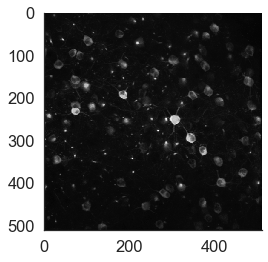

In [11]:
# plot max intensity projection for this experiment
plt.imshow(dataset.max_projection, cmap='gray')

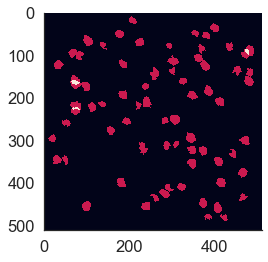

In [12]:
# plot segmentation masks
plt.imshow(dataset.roi_mask_array.sum(axis=0))

In [13]:
# get cell traces
dataset.dff_traces.head(5)

,dff
cell_specimen_id,
829482266,"[0.02217028963299241, 0.05111645700839927, 0.0..."
829482269,"[-0.08213811161298909, 0.02094433551227091, -0..."
829482271,"[0.055718754591026154, -0.031179706314983166, ..."
829482275,"[0.07487296291575361, -0.035264481271238435, -..."
829482277,"[0.07905385120130957, 0.0024523122305217995, -..."


Text(0.5, 16.5, '2P frames')

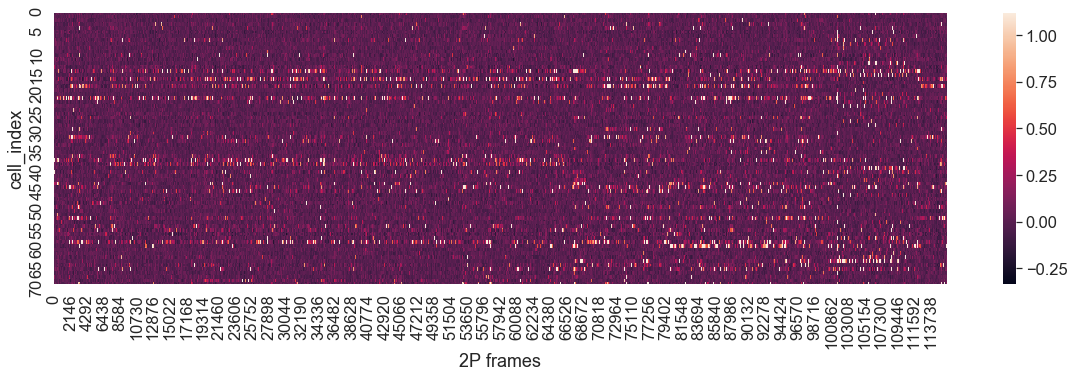

In [14]:
# plot a heatmap of all cell traces (this is slow)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dataset.dff_traces_array, vmax=np.percentile(dataset.dff_traces_array, 99), ax=ax, linecolor=None, linewidth=0)
ax.set_ylabel('cell_index')
ax.set_xlabel('2P frames')

Text(0.5, 0, 'time (sec)')

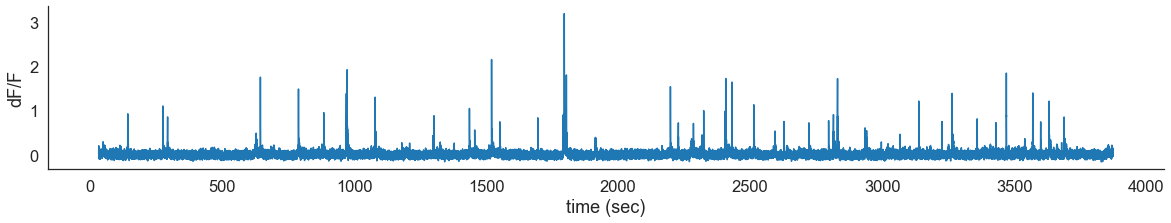

In [15]:
# plot one cell's dF/F trace with x-axis in time in seconds 
cell_specimen_id = dataset.cell_specimen_ids[0]
dff_trace = dataset.dff_traces.loc[cell_specimen_id].values[0]
timestamps = dataset.timestamps_ophys
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(timestamps, dff_trace)
ax.set_ylabel('dF/F')
ax.set_xlabel('time (sec)')

getting L0 events


Text(0.5, 0, 'time (sec)')

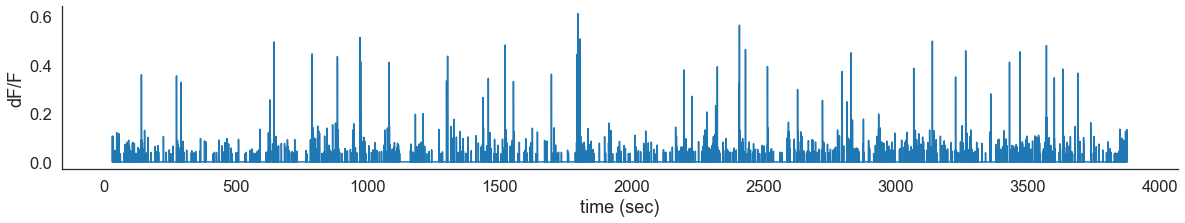

In [16]:
# plot deconvolved calcium events for the same cell
events_trace = dataset.events.loc[cell_specimen_id].values[0]
timestamps = dataset.timestamps_ophys
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(timestamps, events_trace)
ax.set_ylabel('dF/F')
ax.set_xlabel('time (sec)')

Text(0.5, 0, 'time (sec)')

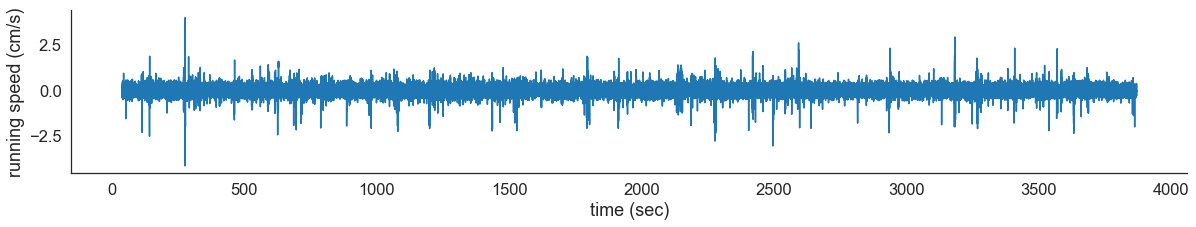

In [17]:
# plot mouse running speed with x-axis in seconds
run_speed = dataset.running_speed.speed.values
timestamps = dataset.running_speed.time.values
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(timestamps, run_speed)
ax.set_ylabel('running speed (cm/s)')
ax.set_xlabel('time (sec)')

looks like this mouse didnt run

In [18]:
# what are the different stimulus types? 
dataset.stimulus_table.session_block_name.unique()

array(['randomized_control_pre', 'oddball', 'transition_control',
       'occlusion', 'natural_movie_one', 'randomized_control_post'],
      dtype=object)

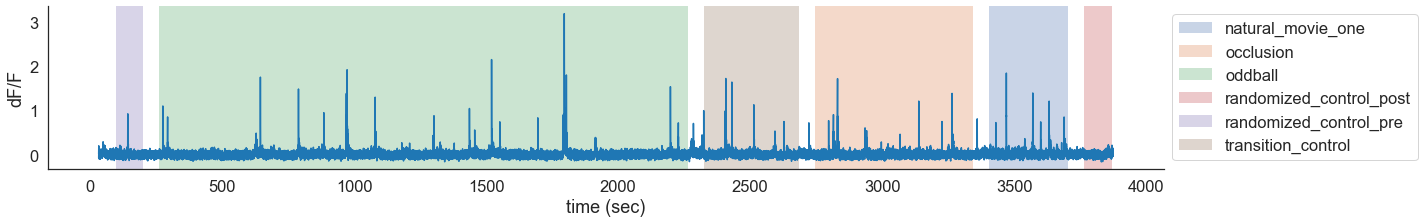

In [19]:
# plot a cell trace with duration of stimulus blocks indicated
dff_trace = dataset.dff_traces.loc[cell_specimen_id].values[0]
timestamps = dataset.timestamps_ophys
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(timestamps, dff_trace)
ax.set_ylabel('dF/F')
ax.set_xlabel('time (sec)')

block_df = dataset.stimulus_block_table.copy()
colors = sns.color_palette('deep')
for i, block_name in enumerate(block_df.block_name.values):
    start_time = block_df[block_df.block_name==block_name].start_time.values[0]
    end_time = block_df[block_df.block_name==block_name].end_time.values[0]
    ax.axvspan(start_time, end_time, facecolor=colors[i], edgecolor='none', alpha=0.3, linewidth=0, zorder=1, label=block_name)
ax.legend(bbox_to_anchor=(1,1))


In [20]:
# stimulus table has times of all stimulus presentations for each of the stimulus types
dataset.stimulus_table.head(3)

,index,sweep,start_frame,end_frame_inclusive,start_time,end_time,session_block_name,image_id,repeat,fraction_occlusion,duration,session_type,stimulus_key,data_file_index,data_file_name,frame_list,mean_running_speed
stimulus_presentations_id,,,,,,,,,,,,,,,,,
0,0,0,3600,3614,97.21053,97.44403,randomized_control_pre,26.0,NaN,NaN,0.25,A,ophys_pilot_randomized_control_A,0,//allen/aibs/technology/nicholasc/openscope/op...,"[3600, 3601, 3602, 3603, 3604, 3605, 3606, 360...",0.071720
1,1,1,3615,3629,97.46070,97.69429,randomized_control_pre,68.0,NaN,NaN,0.25,A,ophys_pilot_randomized_control_A,1,//allen/aibs/technology/nicholasc/openscope/op...,"[3615, 3616, 3617, 3618, 3619, 3620, 3621, 362...",-0.282074
2,2,2,3630,3644,97.71094,97.94444,randomized_control_pre,6.0,NaN,NaN,0.25,A,ophys_pilot_randomized_control_A,2,//allen/aibs/technology/nicholasc/openscope/op...,"[3630, 3631, 3632, 3633, 3634, 3635, 3636, 363...",0.009330


## get cell responses for each stimulus presentation

the ResponseAnalysis class does the work of temporal alignment between 2P times and stimulus times and creates dataframes with the response of every cell for every stimulus in a given stimulus block type. If these dataframes have already been generated, the get_response_df() method loads the saved dataframe. 

In [21]:
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

In [22]:
# set use_events to True if you want responses in events instead of dF/F
analysis = ResponseAnalysis(dataset, use_events=False) 

In [23]:
# what are the stimulus types again? 
dataset.stimulus_block_table

,block_name,start_frame,end_frame,start_time,end_time
0,natural_movie_one,201900,219898,3404.84214,3705.04772
1,occlusion,162330,198270,2744.81699,3344.29405
2,oddball,13500,133485,262.34167,2263.68416
3,randomized_control_post,223500,229785,3765.12887,3869.96230
4,randomized_control_pre,3600,9885,97.21053,202.04375
5,transition_control,137100,158685,2323.98217,2684.01859


In [24]:
# provide the block name to this method to get the stimulus triggered responses for that stimulus type
odf = analysis.get_response_df('oddball')

loading response dataframe for oddball


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
odf.head(3)

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value,index,sweep,start_frame,...,duration,session_type,stimulus_key,data_file_index,data_file_name,frame_list,mean_running_speed,oddball,sequence_start,violation_sequence
0,420,829482266,"[0.020222490744390212, -0.055988010690977655, ...","[-1.990613291893292, -1.9574364036950704, -1.9...",0.017578,-0.009745,0.4170,0,420,13500,...,0.25,A,"(68, 78, 13, 26)",0,//allen/aibs/technology/nicholasc/openscope/68...,"[13500, 13501, 13502, 13503, 13504, 13505, 135...",-0.048806,False,True,False
1,420,829482269,"[-0.06192142547664995, 0.04304486341351953, -0...","[-1.990613291893292, -1.9574364036950704, -1.9...",-0.015661,-0.005818,0.8012,0,420,13500,...,0.25,A,"(68, 78, 13, 26)",0,//allen/aibs/technology/nicholasc/openscope/68...,"[13500, 13501, 13502, 13503, 13504, 13505, 135...",-0.048806,False,True,False
2,420,829482271,"[0.02342878294005412, 0.046452763256736654, 0....","[-1.990613291893292, -1.9574364036950704, -1.9...",0.018385,0.016577,0.3660,0,420,13500,...,0.25,A,"(68, 78, 13, 26)",0,//allen/aibs/technology/nicholasc/openscope/68...,"[13500, 13501, 13502, 13503, 13504, 13505, 135...",-0.048806,False,True,False


In [26]:
odf.keys()

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response', 'p_value',
       'index', 'sweep', 'start_frame', 'end_frame_inclusive', 'start_time',
       'end_time', 'session_block_name', 'image_id', 'repeat',
       'fraction_occlusion', 'duration', 'session_type', 'stimulus_key',
       'data_file_index', 'data_file_name', 'frame_list', 'mean_running_speed',
       'oddball', 'sequence_start', 'violation_sequence'],
      dtype='object')

Text(0, 0.5, 'dF/F')

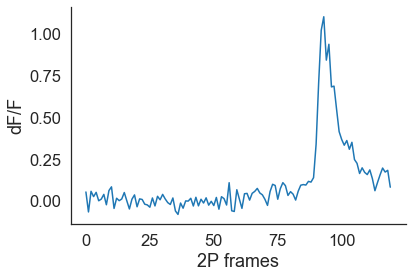

In [27]:
# plot single trial response for one cell
trace = odf[(odf.cell_specimen_id==cell_specimen_id)].trace.values[50]
plt.plot(trace)
plt.xlabel('2P frames')
plt.ylabel('dF/F')

Text(0, 0.5, 'dF/F')

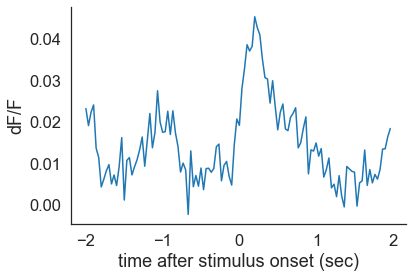

In [28]:
# plot trial averaged response for all oddball images for one cell
mean_trace = odf[(odf.cell_specimen_id==cell_specimen_id)&(odf.oddball==True)].trace.mean()
times = odf[(odf.cell_specimen_id==cell_specimen_id)&(odf.oddball==True)].trace_timestamps.values[0]

fig, ax = plt.subplots()
ax.plot(times, mean_trace)
ax.set_xlabel('time after stimulus onset (sec)')
ax.set_ylabel('dF/F')

Text(0.5, 1.0, 'population response for one oddball trial')

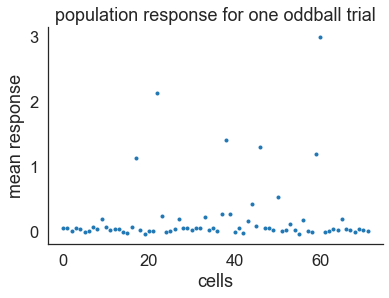

In [29]:
# plot the populatin response vector for one trial - mean response of all cells to that stimulus
# stimulus_presentations_id is the index of each individual stimulus presentation across the entire session
oddball_trials = odf[odf.oddball==True].stimulus_presentations_id.unique()
mean_responses = odf[(odf.stimulus_presentations_id==oddball_trials[9])].mean_response.values
plt.plot(mean_responses, '.')
plt.xlabel('cells')
plt.ylabel('mean response')
plt.title('population response for one oddball trial')

In [30]:
# how many oddball images are there anyway? 
print(len(analysis.oddball_images), 'oddball images')
print('oddball image IDs are', analysis.oddball_images)

10 oddball images
oddball image IDs are [6.0, 17.0, 22.0, 51.0, 71.0, 89.0, 103.0, 110.0, 111.0, 112.0]


In [31]:
# what are the sequence images? 
print('sequence image IDs are', analysis.sequence_images)

sequence image IDs are [68.0, 78.0, 13.0, 26.0]


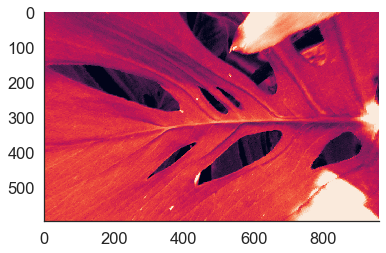

In [32]:
# plot one of the images 
stimulus_template = dataset.get_stimulus_template()
image_id = analysis.sequence_images[1]
plt.imshow(stimulus_template[image_id])

### get trial averaged responses for a set of conditions

In [33]:
# start with dataframe with every cell's response to every stimulus presentation
odf = analysis.get_response_df('oddball')

loading response dataframe for oddball


In [34]:
# utilities has some useful functions for trial averaging, determining significance of response, etc. 
import openscope_predictive_coding.ophys.response_analysis.utilities as ut

In [35]:
# the get_mean_df() function gets trial averaged responses and other metrics for a set of conditions 
conditions=['cell_specimen_id', 'oddball', 'image_id'] # columns in response dataframe over which to groupby
oddball_mean_df = ut.get_mean_df(odf, conditions=conditions)

In [36]:
oddball_mean_df.head()

,index,cell_specimen_id,oddball,image_id,mean_response,sem_response,mean_trace,sem_trace,pref_stim,fraction_significant_trials,fraction_responsive_trials
0,0,829482266,False,13.0,0.019421,0.002238,"[0.018599499249567462, 0.017350379152847723, 0...","[0.00195665688100999, 0.0022853478889058314, 0...",False,0.017000,0.042000
1,1,829482266,False,26.0,0.014624,0.002069,"[0.022781207802966785, 0.01966453978135488, 0....","[0.002888825835157495, 0.0028417273214166486, ...",False,0.012632,0.035789
2,2,829482266,False,68.0,0.012886,0.001497,"[0.012312569810942151, 0.012522726916159937, 0...","[0.0021874886622547393, 0.0020502090220063844,...",False,0.008000,0.033000
3,3,829482266,False,78.0,0.016918,0.001651,"[0.010273554304274077, 0.011579506693316923, 0...","[0.001659922848022397, 0.0015686741350607934, ...",False,0.012500,0.041000
4,4,829482266,True,6.0,0.026478,0.006619,"[0.02163839779939416, -0.006000974697554415, -...","[0.00963872610068699, 0.01292199048345216, 0.0...",False,0.000000,0.000000


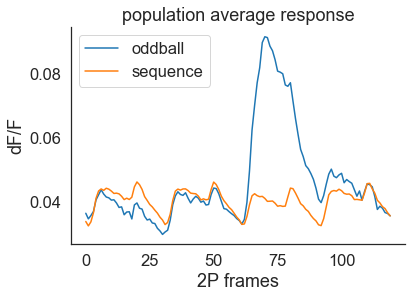

In [37]:
# plot the average response for oddball and sequence images
last_in_sequence = analysis.sequence_images[-1] 
plt.plot(oddball_mean_df[oddball_mean_df.oddball==True].mean_trace.mean(), label='oddball')
plt.plot(oddball_mean_df[oddball_mean_df.image_id==last_in_sequence].mean_trace.mean(), label='sequence')
plt.title('population average response')
plt.xlabel('2P frames')
plt.ylabel('dF/F')
plt.legend()

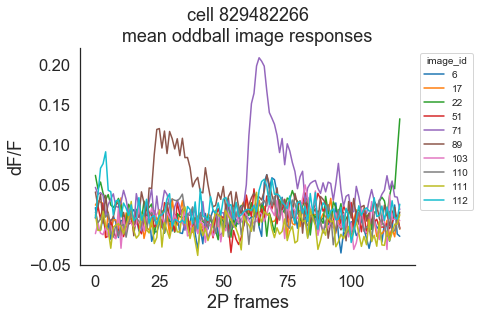

In [38]:
# plot mean response across oddball images for some cell
cell_data = oddball_mean_df[oddball_mean_df.cell_specimen_id==cell_specimen_id]
for image_id in analysis.oddball_images: 
    trace = cell_data[cell_data.image_id==image_id].mean_trace.values[0]
    plt.plot(trace, label=int(image_id))
plt.xlabel('2P frames')
plt.ylabel('dF/F')
plt.title('cell '+str(cell_specimen_id)+'\nmean oddball image responses')
plt.legend(bbox_to_anchor=(1,1), fontsize='medium', title='image_id')